# Try Diffusion Model
[reference](https://www.peterholderrieth.com/blog/2023/Diffusion-Models-From-Scratch-1d-Manifold/)

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

def manifold_func(x):
    return x**2

N_samples = 10000
x = torch.rand(N_samples)
y = manifold_func(x)
data = torch.stack([x,y],axis=1)

In [3]:
from torch.utils.data import Dataset, DataLoader
class ManifoldDataset(Dataset):
    def __init__(self, data: torch.Tensor):
        super().__init__()
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

dataset = ManifoldDataset(data)
batch_size = 128
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
class ItoSDE:
    def __init__(self, T_max: float):
        self.T_max = T_max
    def cond_exp(self, X_0: torch.Tensor, t: torch.Tensor):
        return NotImplementedError
    def cond_var(self, X_0: torch.Tensor, t: torch.Tensor):
        return NotImplementedError
    def f_drift(self, X_t: torch.Tensor, t: torch.Tensor):
        return NotImplementedError
    def g_random(self, X_t: torch.Tensor, t: torch.Tensor):
        return NotImplementedError
    def cond_std(self, X_0: torch.Tensor, t: torch.Tensor):
        return torch.sqrt(self.cond_var(X_0=X_0, t=t))
    
    def sample_random_times(self, length: int):
        return torch.rand(length) * self.T_max
    def run_forward(self, X_0: torch.Tensor, t: torch.Tensor):
        noise = torch.randn(X_0.shape)
        cond_std = self.cond_std(X_0, t)
        cond_exp = self.cond_exp(X_0, t)
        X_t = cond_exp + mult_first_dim(noise, cond_std)
        cond_std = torch.clip(cond_std, min=0.01)
        score = -mult_first_dim(noise, 1 / cond_std)
        return X_t, noise, score
    def run_forward_random_time(self, X_0: torch.Tensor):
        t = self.sample_random_times(X_0.shape[0])
        X_t, noise, score = self.run_forward(X_0=X_0, t=t)
        return X_t, noise, score, t

def mult_first_dim(X: torch.Tensor, t: torch.Tensor):
    return t.view(-1,*[1]*(X.dim()-1))*X

class VPSDE(ItoSDE):
    def __init__(self, T_max: float, beta_min: float=0.0, beta_max: float=1.0):
        super().__init__(T_max)
        self.beta_min = beta_min
        self.beta_max = beta_max
    def _beta_prime(self, t: torch.Tensor):
        return self.beta_min + (self.beta_max - self.beta_min)*t
    def _beta(self, t: torch.Tensor):
        return (self.beta_min*t) + 0.5*(self.beta_max - self.beta_min)*(t**2)
    def cond_exp(self, X_0, t):
        beta_t = self._beta(t)
        cond_exp_t = torch.exp(-0.5 * beta_t)
        return mult_first_dim(X_0, cond_exp_t)
    def cond_var(self, X_0, t):
        beta_t = self._beta(t)
        return 1- torch.exp(-beta_t)
    
    def f_drift(self, X_t, t):
        beta_prime = self._beta_prime(t)
        return -0.5 * mult_first_dim(X_t, beta_prime)
    def g_random(self, t):
        beta_prime = self._beta_prime(t)
        return torch.sqrt(beta_prime)

vpsde = VPSDE(T_max=1, beta_min=0.01, beta_max=2.0)

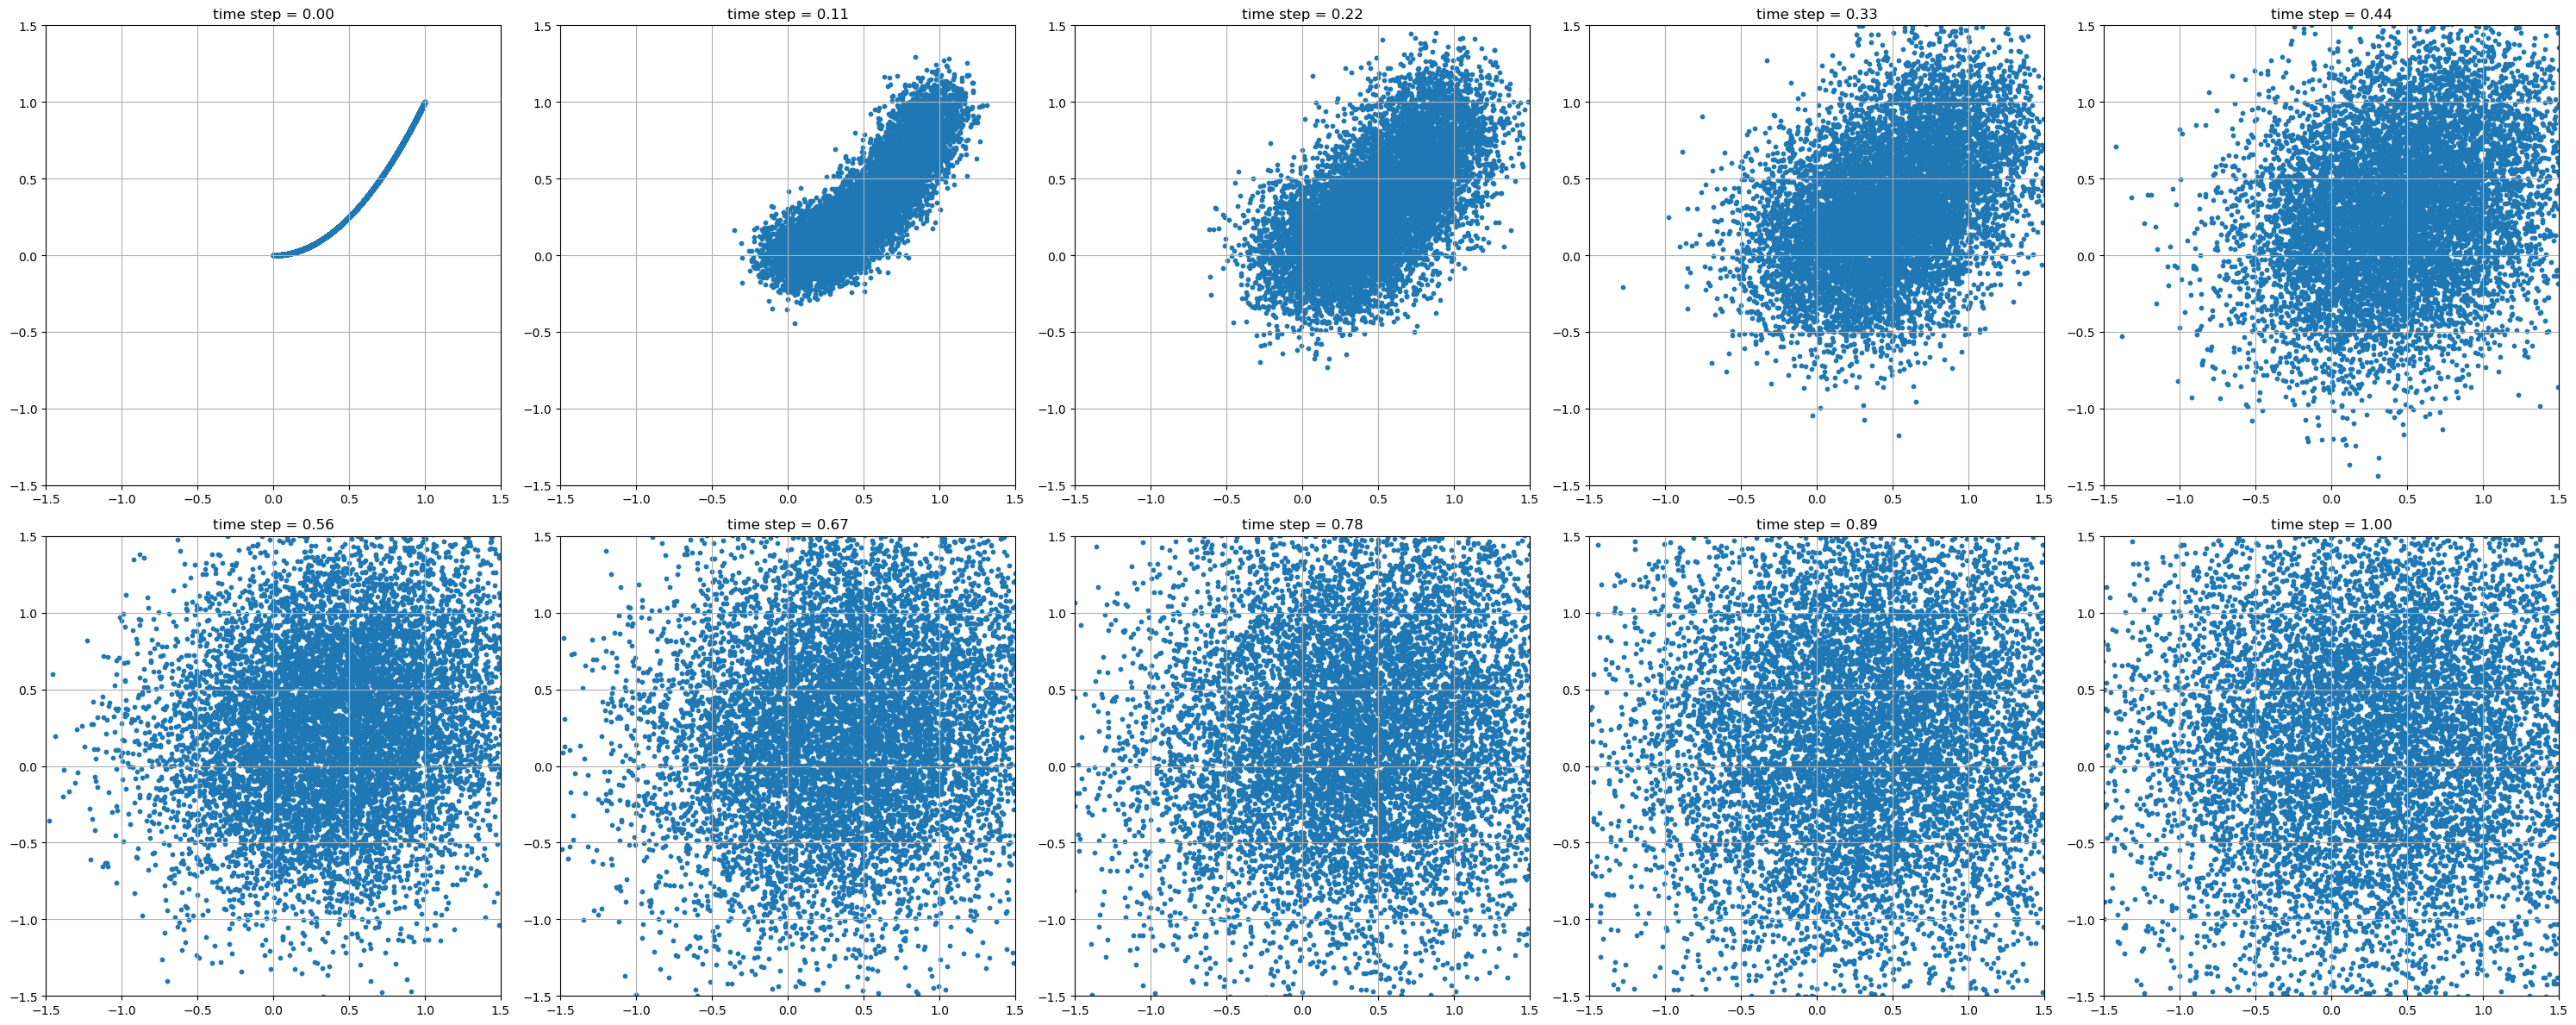

In [4]:
n_time_slides = 10
t = torch.linspace(0, 1, n_time_slides)
X_0 = torch.stack([torch.stack([dataset[idx]]*n_time_slides) for idx in range(10000)]).transpose(1, 0)
X_t, noise, score = vpsde.run_forward(X_0, t)
fig, axs = plt.subplots(2, n_time_slides//2, figsize=(3 * n_time_slides, 12))

for idx in range(n_time_slides):
    row = idx // 5
    col = idx % 5
    axs[row, col].scatter(X_t[idx, :, 0], X_t[idx, :, 1], s=10) 
    axs[row, col].set_xlim(-1.5, 1.5)
    axs[row, col].set_ylim(-1.5, 1.5)
    axs[row, col].set_title(f"time step = {t[idx]:.2f}")
    axs[row, col].grid(True)  
plt.tight_layout()
plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F
class FCNScoreModel(nn.Module):
    def __init__(self, input_size: int=2, hidden_size: int=128, n_hidden_layers: int=2):
        super().__init__()
        self.input_layer = nn.Linear(input_size + 1, hidden_size)
        self.input_batch_norm = nn.BatchNorm1d(hidden_size)
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_hidden_layers):
            layer = nn.Linear(hidden_size, hidden_size)
            batch_norm = nn.BatchNorm1d(hidden_size)
            self.hidden_layers.append(nn.Sequential(layer, batch_norm))
        self.output_layer = nn.Linear(hidden_size, input_size)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        input = torch.concat([x, t.unsqueeze(1)], dim=1)
        x = F.relu(self.input_batch_norm(self.input_layer(input)))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        return self.output_layer(x)
    
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FCNScoreModel().to(device)
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-5
N_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)


In [6]:
def train(model, sde: ItoSDE, dataloader: DataLoader, optimizer, device, scheduler: None, n_epochs: int, train_score: bool=False):
    model.train()
    loss_function = nn.MSELoss(reduction='mean')
    loss_list = []
    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        for idx, X_0 in enumerate(dataloader):
            # print(X_0.shape, idx)
            optimizer.zero_grad()
            X_t, noise, score, time = sde.run_forward_random_time(X_0)
            X_t = X_t.to(device); noise = noise.to(device); time = time.to(device); score = score.to(device)
            score_pred = model(X_t, time)
            if train_score:
                loss = loss_function(score, score_pred)
            else:
                loss = loss_function(noise, score_pred)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.detach().item())
            print(loss.detach().item())
            if scheduler:
                scheduler.step()
    return model, loss_list
model, loss_list = train(model=model, sde=vpsde, dataloader=trainloader, scheduler=None, optimizer=optimizer, device=device, n_epochs=N_EPOCHS)

Epoch: 0
1.2390644550323486
1.235762119293213
1.2678203582763672
1.2678768634796143
1.1739122867584229
1.0637625455856323
1.015376091003418
1.1385586261749268
1.0338445901870728
1.2936460971832275
1.0108165740966797
0.9480443000793457
1.0268902778625488
0.9787163734436035
0.9898959994316101
1.0754141807556152
1.0457465648651123
1.1080790758132935
0.995123565196991
1.0988110303878784
0.8010650873184204
1.0207016468048096
1.0373752117156982
0.8482198715209961
0.9451729655265808
0.9414645433425903
0.799029529094696
0.8099139928817749
0.7489689588546753
0.7821389436721802
0.9454332590103149
0.8289645910263062
0.7255473136901855
0.8040164709091187
0.7101489305496216
0.8201242685317993
0.6860368847846985
0.8728918433189392
0.8077169060707092
0.8809801936149597
0.7305221557617188
0.707375168800354
0.714565098285675
0.7548258304595947
0.8307291269302368
0.7255709171295166
0.7193194627761841
0.6116997003555298
0.6707548499107361
0.7655383944511414
0.6522040367126465
0.7004969120025635
0.5793834

d:\Anaconda\envs\pytorch\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Axes: >

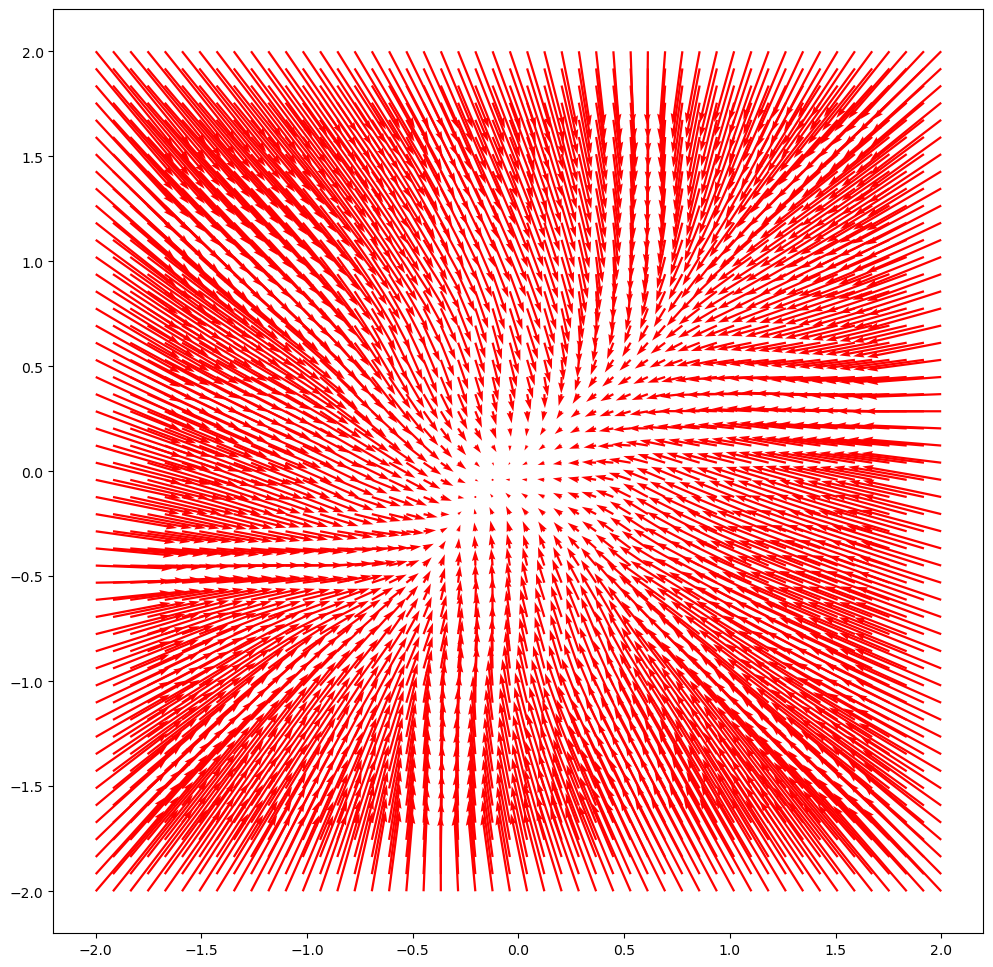

In [7]:
from typing import List, Callable
from itertools import product
def plot_score_vector_field(score_func: Callable, t: torch.Tensor, sde: VPSDE, min_x: float = -2.0, max_x: float = 2.0, n_grid_points: int = 50):
    oned_grid = torch.linspace(min_x, max_x, n_grid_points)
    x_grid, y_grid = torch.meshgrid(oned_grid, oned_grid)
    twod_grid = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)
    cond_std = sde.cond_var(twod_grid, t)
    t = t.expand(twod_grid.shape[0])
    extent = [oned_grid.min(), oned_grid.max(), oned_grid.min(), oned_grid.max()]
    score = -score_func(x=twod_grid, t=t)/cond_std
    score = score.detach().numpy()

    fig, my_axis = plt.subplots(figsize=(12,12))
    my_axis.quiver(twod_grid[:,0],twod_grid[:,1],score[:,0],score[:,1], scale=100000.0, color='r')
    return my_axis
model = model.to('cpu')
plot_score_vector_field(score_func=model, t=torch.tensor(0.01), sde=vpsde)

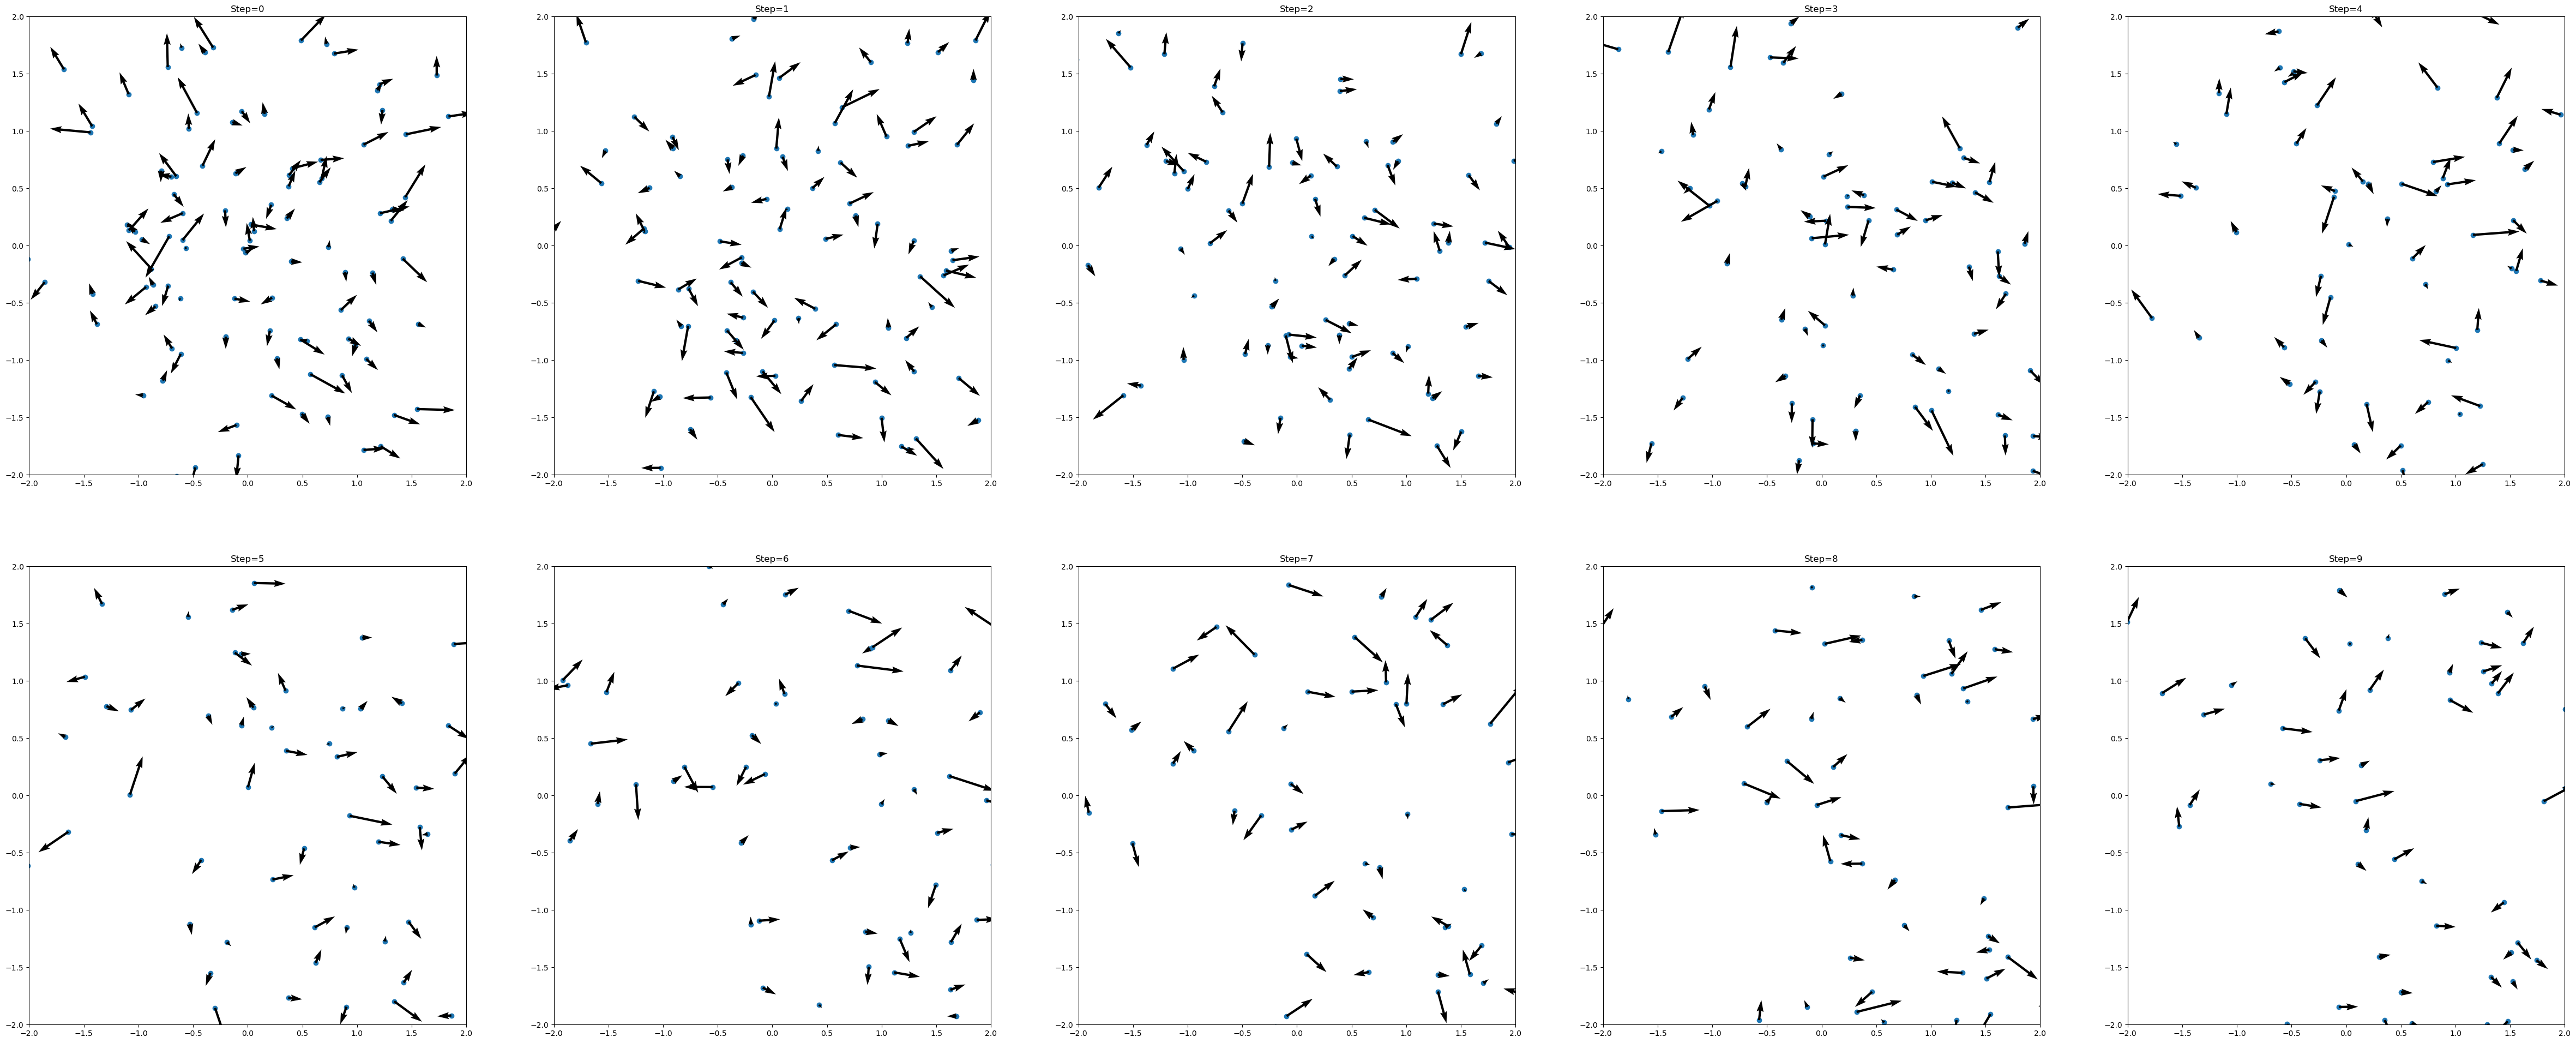

In [6]:
def run_backwards(model: torch.nn.Module, sde: VPSDE, X_0: torch.Tensor, device, train_score: bool=False, n_steps: int=10, plot_evolution: bool=True):
    model = model.to(device)
    n_traj = X_0.shape[0]
    time_grid = torch.linspace(sde.T_max, 0, n_steps)
    dt = torch.abs(time_grid[0] - time_grid[1])
    diffusion_g = sde.g_random(t=time_grid)
    noise = torch.randn(size=(n_steps, *list(X_0.shape)))
    diffusion_term_grid = mult_first_dim(noise, torch.sqrt(dt) * diffusion_g)
    x_traj = [X_0]
    if plot_evolution:
        n_col = len(time_grid)//2
        fig, axs = plt.subplots(2, n_col,figsize=(12*n_col, 24))
    for idx, t in enumerate(time_grid):
        x = x_traj[idx]
        t = t.repeat(n_traj)
        drift_term = sde.f_drift(x, t) * dt
        diffusion_term = diffusion_term_grid[idx]
        model_estimate = model(x.to(device), t.to(device)).detach().to('cpu')
        if train_score:
            score_estimates = model_estimate
        else:
            denominator = torch.clip(sde.cond_std(None, t), 0.01)
            score_estimates = -mult_first_dim(model_estimate, 1/denominator)
        g_squared = (diffusion_g[idx] ** 2).repeat(n_traj)
        
        correction_term = dt * mult_first_dim(score_estimates, g_squared)
        change = (correction_term - drift_term) + diffusion_term
        x_next = x + change
        x_traj.append(x_next)
        if plot_evolution:
            row = idx // n_col
            col = idx % n_col
            axs[row, col].scatter(x_next[:,0], x_next[:,1])
            axs[row, col].quiver(x_next[:,0], x_next[:,1], change[:,0],change[:,1])
            axs[row, col].set_xlim(-2.0,2.0)
            axs[row, col].set_ylim(-2.0,2.0)
            axs[row, col].set_title(f"Step={idx}")
    output = torch.stack(x_traj)
    return output, time_grid

x_start = torch.randn(size=next(enumerate(trainloader))[1].shape)
output, time_grid = run_backwards(model=model, sde=vpsde, X_0=x_start, device=device)